# Evaluación Final Módulo 3

In [216]:
# IMPORTAMOS LAS LIBRERÍAS QUE NECESITAMOS

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Imputación de nulos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer 
from sklearn.experimental import enable_iterative_imputer # Necesario para IterativeImputer
from sklearn.impute import IterativeImputer 
from sklearn.impute import KNNImputer 

# Visualización
# -----------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------
import scipy.stats as st
import scipy.stats as stats
from scipy.stats import shapiro, poisson, chisquare, expon, kstest

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

In [217]:
# FUNCIONES: 

# Visualización rápida de los datos: 
# -----------------------------------------------------------------------
def visualizacion_datos(dataframe): 
    print('VISUALIZACIÓN RÁPIDA DE LOS DATOS:')
    print('--' * 17)
    display(dataframe.head(3))
    display(dataframe.tail(3))
    display(dataframe.sample(3))
    print('--' * 120)
    print(f'El número de filas es de {dataframe.shape[0]} y el número de columnas es de {dataframe.shape[1]}.')
    print('Las diferentes columnas que tenemos son:')
    num = 0
    for i in dataframe.columns: 
        num +=1
        print(f'    {num}. {i}')
    print('--' * 120)
    print('INFORMACIÓN DEL CONJUNTO DE DATOS:')
    print('--' * 17)
    dataframe.info()

# Duplicados:
# ----------------------------------------------------------------------- 
def func_duplicados(dataframe): 
    if dataframe.duplicated().sum() > 0:
        print(f'El número de filas es de {dataframe.shape[0]}')
        print(f'El número de duplicados es: {dataframe.duplicated().sum()}.')
        print('Borrando duplicados...')
        dataframe.drop_duplicates(inplace = True)
        print(f'Se han eliminado los duplicados.')
        print(f'Comprobando que el número de duplicados sea cero.')
        print(f'Comprobación: {dataframe.duplicated().sum()}')
        print(f'Ahora el número de filas es: {dataframe.shape[0]}')
    else: 
        print('Este dataframe no tiene duplicados.')

# Valores nulos
# -----------------------------------------------------------------------------------------------
# Con esta función podemos saber que variables de nuestro dataframe y en que porcentaje 
# tienen valores nulos. 
# Nos devuleve el nombre de las columnas que tiene dichos valores nulos, de manera que podemos 
# guardarlas en una variable (lista), por si se necesitan a posteriori.
# ----------------------------------------------------------------------------------------------- 
def variables_nulas(dataframe): 
    nulos = (dataframe.isnull().sum()/dataframe.shape[0]*100).reset_index()
    nulos.rename(columns={'index': 'columna', 0:'%_nulos'}, inplace=True)
    mascara = nulos['%_nulos'] > 0

    if nulos['%_nulos'].sum() == 0: 
        print('Ninguna columna tiene valores nulos. Puedes continuar con tu estudio.')
    else: 
        col_nulos = nulos.loc[nulos['%_nulos']!=0, 'columna'].to_list() 
        display(nulos[mascara])
        for i in col_nulos:
            print(f'La siguiente columna tiene valores nulos: {i}')
        return col_nulos
    

# Creación de boxplots: 
# -----------------------------------------------------------------------------------------------
## FUNCIÓN PARA CREAR BOXPLOTS EN ANÁLISIS DE VARIABLES NUMÉRICAS: 
# Esta función hay que indicarle dos cosas: la primera es el dataframe y el segundo son las 
# columnas del dataframe que queremos hacer los boxplots.
# Devuelve la representación del boxplot, la media y la mediana.  
# IMPORTANTE: Las columnas se tienen que dar en una lista y las calumnas deben de ser numéricas. 
# -----------------------------------------------------------------------------------------------

def avn_boxplot(dataframe, columna): 
    for var in columna:
        sns.boxplot(data=dataframe, x=var)
        mean_var = round(dataframe[var].mean(), 2)
        median_var = round(dataframe[var].median(), 2)
        plt.axvline(x=mean_var, color = 'red', linestyle = '--', linewidth = 2, label = f'Media: {mean_var}')
        plt.axvline(x=median_var, color = 'green', linestyle = '--', linewidth = 2, label = f'Mediana: {median_var}')
        plt.legend()
        plt.show();

### FASE 1: Exploración y limpieza.

1. **Exploración inicial:**

    - Realiza una exploración inicial de los datos para identificar posibles problemas, como valores nulos, atípicos o datos faltantes en las columnas relevantes.
    - Utiliza funciones de Pandas para obtener información sobre la estructura de los datos, la presencia de valores nulos y estadísticas básicas de las columnas involucradas.
    - Une los dos conjuntos de datos de la forma más eficiente.



2. **Limpieza de datos:**

    - Elimina o trata los valores nulos, si los hay, en las columnas clave para asegurar que los datos estén completos.
    - Verifica la consistencia y corrección de los datos para asegurarte de que los datos se presenten de forma coherente.
    - Realiza cualquier ajuste o conversión necesaria en las columnas (por ejemplo, cambiar tipos de datos) para garantizar la adecuación de los datos para el análisis estadístico.

In [218]:
## Cargamos los datos de ambos ficheros: 

df_CFA = pd.read_csv('data/Customer-Flight-Activity.csv')
df_CLH = pd.read_csv('data/Customer-Loyalty-History.csv')

En primer lugar se estudiará el conjunto de datos "Customer Fligth Analysis" y posteriormente, se hará lo mismo con el conjunto de datos "Customer Loyalty History".

## **Dataframe 1**: Customer Fligth Analysis 

Este archivo contiene información sobre la actividad de vuelo de los clientes, incluyendo el número de vuelos reservados, la distancia volada, puntos acumulados y redimidos, y costos asociados a los puntos redimidos. 

- **Loyalty Number**: Este atributo representa un identificador único para cada cliente dentro del programa de lealtad de la aerolínea. Cada número de lealtad corresponde a un cliente específico.
- **Year**: Indica el año en el cual se registraron las actividades de vuelo para el cliente.
- **Month**: Representa el mes del año (de 1 a 12) en el cual ocurrieron las actividades de vuelo.
- **Flights Booked**: Número total de vuelos reservados por el cliente en ese mes específico.
- **Flights with Companions**: Número de vuelos reservados en los cuales el cliente viajó con acompañantes.
- **Total Flights**: El número total de vuelos que el cliente ha realizado, que puede incluir vuelos reservados en meses anteriores.
- **Distance**: La distancia total (presumiblemente en millas o kilómetros) que el cliente ha volado durante el mes.
- **Points Accumulated**: Puntos acumulados por el cliente en el programa de lealtad durante el mes, con base en la distancia volada u otros factores.
- **Points Redeemed**: Puntos que el cliente ha redimido en el mes, posiblemente para obtener beneficios como vuelos gratis, mejoras, etc.
- **Dollar Cost Points Redeemed**: El valor en dólares de los puntos que el cliente ha redimido durante el mes.

In [219]:
visualizacion_datos(df_CFA)

VISUALIZACIÓN RÁPIDA DE LOS DATOS:
----------------------------------


,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100018,2017,1,3,0,3,1521,152.0,0,0
1,100102,2017,1,10,4,14,2030,203.0,0,0
2,100140,2017,1,6,0,6,1200,120.0,0,0


,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
405621,999940,2018,12,3,0,3,1233,123.0,0,0
405622,999982,2018,12,0,0,0,0,0.0,0,0
405623,999986,2018,12,0,0,0,0,0.0,0,0


,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
367811,921530,2018,4,0,0,0,0,0.0,0,0
97823,316323,2017,5,0,0,0,0,0.0,0,0
13289,804784,2017,1,0,0,0,0,0.0,0,0


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
El número de filas es de 405624 y el número de columnas es de 10.
Las diferentes columnas que tenemos son:
    1. Loyalty Number
    2. Year
    3. Month
    4. Flights Booked
    5. Flights with Companions
    6. Total Flights
    7. Distance
    8. Points Accumulated
    9. Points Redeemed
    10. Dollar Cost Points Redeemed
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
INFORMACIÓN DEL CONJUNTO DE DATOS:
----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 10 columns):
 #   Col

In [220]:
# Ninguna variable tiene valores nulos. 

In [221]:
# Vamos a homogeneizar los nombres de las columnas, siendo el cambio que le vamos a hacer quitar los espacios en los nombres y sustituirlos por 
# barras bajas (_); ya que tener espacios en los nombres de nuestras columnas pueden llevar a errores cuando queramos realizar algunos comandos. 

new_col = {col: col.replace(' ', '_') for col in df_CFA.columns}
df_CFA.rename(columns=new_col, inplace=True)
df_CFA.columns

Index(['Loyalty_Number', 'Year', 'Month', 'Flights_Booked',
       'Flights_with_Companions', 'Total_Flights', 'Distance',
       'Points_Accumulated', 'Points_Redeemed', 'Dollar_Cost_Points_Redeemed'],
      dtype='object')

In [222]:
# Vamos a realizar un análisis descriptivo de los datos para poder tener una idea general de los mismos. 
df_CFA.describe().T

,count,mean,std,min,25%,50%,75%,max
Loyalty_Number,405624.0,550037.873084,258935.286969,100018.0,326961.00,550834.0,772194.00,999986.0
Year,405624.0,2017.500000,0.500001,2017.0,2017.00,2017.5,2018.00,2018.0
Month,405624.0,6.500000,3.452057,1.0,3.75,6.5,9.25,12.0
Flights_Booked,405624.0,4.115052,5.225518,0.0,0.00,1.0,8.00,21.0
Flights_with_Companions,405624.0,1.031805,2.076869,0.0,0.00,0.0,1.00,11.0
Total_Flights,405624.0,5.146858,6.521227,0.0,0.00,1.0,10.00,32.0
Distance,405624.0,1208.880059,1433.155320,0.0,0.00,488.0,2336.00,6293.0
Points_Accumulated,405624.0,123.692721,146.599831,0.0,0.00,50.0,239.00,676.5
Points_Redeemed,405624.0,30.696872,125.486049,0.0,0.00,0.0,0.00,876.0
Dollar_Cost_Points_Redeemed,405624.0,2.484503,10.150038,0.0,0.00,0.0,0.00,71.0


In [223]:
# En nuestro conjunto de datos no existe ninguna variable que sea de tipo categórica, por lo que no tenemos que hacer un 
# análisis estadístico a parte de este tipo de variables.

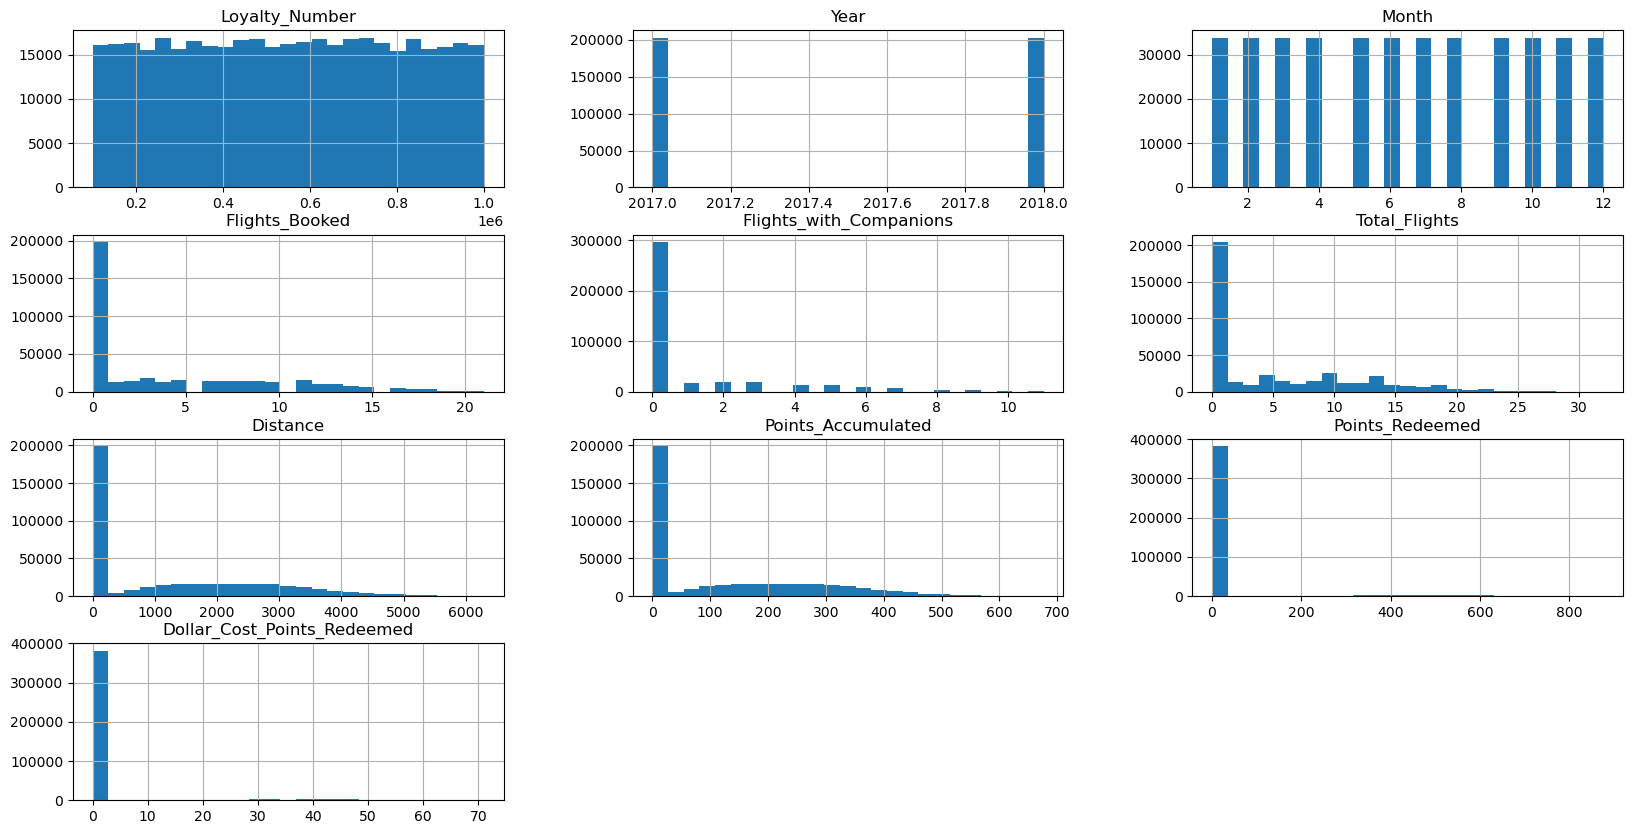

In [224]:
# Vamos a hacer un análisis de las variables. 

# Histograma: 

df_CFA.hist(bins=25, figsize=(20, 10));

In [225]:
# Aunque realizamos los histogramas de todas las columnas, no tendría mucho sentido hacerlas, ya que algunas variables como puede ser "Loyalty Number" no 
# niene sentido representarla porque es un identificador único de cliente o "Flights Booked", ya que son el total de vuelos reservados por el cliente en 
# un mes específico y sin tener en cuenta el mes, no tiene sentido su representación. 

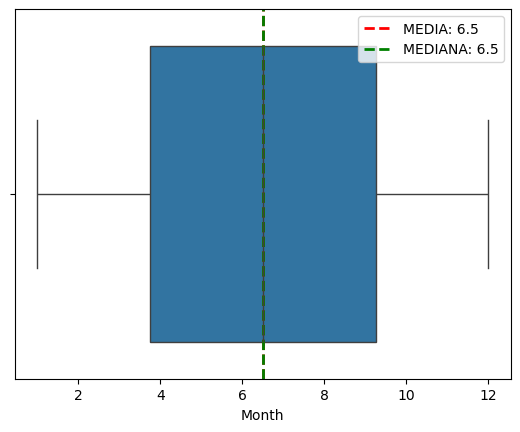

In [226]:
# Vamos a hacer unos boxplots de aquellas variables que parezca tener más sentido representar.

sns.boxplot(data = df_CFA, x = 'Month')
mean_month = df_CFA['Month'].mean()
median_month = df_CFA['Month'].median()
plt.axvline(x = mean_month, color = 'red', linestyle='--', linewidth = 2, label = f"MEDIA: {mean_month}")
plt.axvline(x = median_month, color = 'green', linestyle='--', linewidth = 2, label = f"MEDIANA: {median_month}")
plt.legend();


In [227]:
# Realizar un boxplots con la variable 'Month', no nos arroja grandes conclusiones, ya que para todos los meses tenemos el mismo número de datos.
df_CFA['Month'].value_counts()

Month
1     33802
9     33802
2     33802
3     33802
11    33802
4     33802
5     33802
7     33802
6     33802
8     33802
10    33802
12    33802
Name: count, dtype: int64

In [228]:
# DUPLICADOS: 
# Con esta función vamos a ver si tenemos duplicados y en el caso de tenerlos los va a eliminar. 
func_duplicados(df_CFA)

El número de filas es de 405624
El número de duplicados es: 1864.
Borrando duplicados...
Se han eliminado los duplicados.
Comprobando que el número de duplicados sea cero.
Comprobación: 0
Ahora el número de filas es: 403760


In [229]:
# NULOS: 
nulos_CFA = variables_nulas(df_CFA)

Ninguna columna tiene valores nulos. Puedes continuar con tu estudio.


Este dataframe no tiene valores nulos por lo que no tenemos que hacer imputaciones en el mismo. 

Pasamos al dataframe "Customer Loyalty History" para realizarle también la exploración y limpieza de datos.

## **Dataframe 2**: Customer Loyalty History 

Este archivo proporciona un perfil detallado de los clientes, incluyendo su ubicación, nivel educativo, ingresos, estado civil, y detalles sobre su membresía en el programa de lealtad (como el tipo de tarjeta, valor de vida del cliente, y fechas de inscripción y cancelación).

- **Loyalty Number**: Identificador único del cliente dentro del programa de lealtad. Este número permite correlacionar la información de este archivo con el archivo de actividad de vuelos.
- **Country**: País de residencia del cliente.
- **Province**: Provincia o estado de residencia del cliente (aplicable a países con divisiones provinciales o estatales, como Canadá).
- **City**: Ciudad de residencia del cliente.
- **Postal Code**: Código postal del cliente.
- **Gender**: Género del cliente (ej. Male para masculino y Female para femenino).
- **Education**: Nivel educativo alcanzado por el cliente (ej. Bachelor para licenciatura, College para estudios universitarios o técnicos, etc.).
- **Salary**: Ingreso anual estimado del cliente.
- **Marital Status**: Estado civil del cliente (ej. Single para soltero, Married para casado, Divorced para divorciado, etc.).
- **Loyalty Card**: Tipo de tarjeta de lealtad que posee el cliente. Esto podría indicar distintos niveles o categorías dentro del programa de lealtad.
- **CLV (Customer Lifetime Value)**: Valor total estimado que el cliente aporta a la empresa durante toda la relación que mantiene con ella.
- **Enrollment Type**: Tipo de inscripción del cliente en el programa de lealtad (ej. Standard).
- **Enrollment Year**: Año en que el cliente se inscribió en el programa de lealtad.
- **Enrollment Month**: Mes en que el cliente se inscribió en el programa de lealtad.
- **Cancellation Year**: Año en que el cliente canceló su membresía en el programa de lealtad, si aplica.
- **Cancellation Month**: Mes en que el cliente canceló su membresía en el programa de lealtad, si aplica.


In [230]:
visualizacion_datos(df_CLH)

VISUALIZACIÓN RÁPIDA DE LOS DATOS:
----------------------------------


,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018.0,1.0


,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
16734,776187,Canada,British Columbia,Vancouver,V5R 1W3,Male,College,NaN,Single,Star,74228.52,Standard,2014,3,NaN,NaN
16735,906428,Canada,Yukon,Whitehorse,Y2K 6R0,Male,Bachelor,-57297.0,Married,Star,10018.66,2018 Promotion,2018,4,NaN,NaN
16736,652627,Canada,Manitoba,Winnipeg,R2C 0M5,Female,Bachelor,75049.0,Married,Star,83325.38,Standard,2015,12,2016.0,8.0


,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
13625,799064,Canada,Ontario,Thunder Bay,K8T 5M5,Female,Bachelor,49982.0,Married,Star,5379.48,Standard,2018,8,NaN,NaN
12302,607662,Canada,British Columbia,Vancouver,V6E 3D9,Female,College,NaN,Single,Star,3539.97,Standard,2016,1,NaN,NaN
13401,564973,Canada,British Columbia,Vancouver,V5R 1W3,Female,Bachelor,60641.0,Married,Star,5143.88,Standard,2017,2,NaN,NaN


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
El número de filas es de 16737 y el número de columnas es de 16.
Las diferentes columnas que tenemos son:
    1. Loyalty Number
    2. Country
    3. Province
    4. City
    5. Postal Code
    6. Gender
    7. Education
    8. Salary
    9. Marital Status
    10. Loyalty Card
    11. CLV
    12. Enrollment Type
    13. Enrollment Year
    14. Enrollment Month
    15. Cancellation Year
    16. Cancellation Month
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
INFORMACIÓN DEL CONJUNTO DE DATOS:
----------------------------------
<class 'pandas.core.frame.DataFr

In [231]:
# Podemos observar que de las 16 columnas o variables, hay tres que sí tienen valores nulos. Ahora veremos que hacer con estas variables. 
# Lo primero que vamos a hacer antes de continuar es a homogeneizar los nombres de las columnas, en este caso, el cambio que vamos a hacer 
# es quitar los espacios entre palabras y sustituirlos por barras bajas (_). Realizamos este cambio debido a que tener el nombre escrito 
# de esta forma nos puede dar problemas a la hora de realizar nuestro análisis.

new_col = {col: col.replace(' ', '_') for col in df_CLH.columns}
df_CLH.rename(columns=new_col, inplace=True)
df_CLH.columns



Index(['Loyalty_Number', 'Country', 'Province', 'City', 'Postal_Code',
       'Gender', 'Education', 'Salary', 'Marital_Status', 'Loyalty_Card',
       'CLV', 'Enrollment_Type', 'Enrollment_Year', 'Enrollment_Month',
       'Cancellation_Year', 'Cancellation_Month'],
      dtype='object')

In [232]:
# Vamos a realizar un análisis descriptivo de los datos para poder tener una idea general de los mismos antes de pasar con las 
# columnas con variables nulos. 
df_CLH.describe().T

,count,mean,std,min,25%,50%,75%,max
Loyalty_Number,16737.0,549735.880445,258912.132453,100018.00,326603.00,550434.00,772019.00,999986.00
Salary,12499.0,79245.609409,35008.297285,-58486.00,59246.50,73455.00,88517.50,407228.00
CLV,16737.0,7988.896536,6860.982280,1898.01,3980.84,5780.18,8940.58,83325.38
Enrollment_Year,16737.0,2015.253211,1.979111,2012.00,2014.00,2015.00,2017.00,2018.00
Enrollment_Month,16737.0,6.669116,3.398958,1.00,4.00,7.00,10.00,12.00
Cancellation_Year,2067.0,2016.503145,1.380743,2013.00,2016.00,2017.00,2018.00,2018.00
Cancellation_Month,2067.0,6.962748,3.455297,1.00,4.00,7.00,10.00,12.00


In [233]:
# Como podemos observar, de las 16 variables que tenemos solo nos ha hecho el análisis de 7, esto es debido a que solo 
# esas 7 variables están consideradas como numéricas, el resto son categóricas. 

# A continuación, vamos a realizar este mismo análisis descriptivo pero para las variables categóricas:
df_CLH.describe(include='O').T

,count,unique,top,freq
Country,16737,1,Canada,16737
Province,16737,11,Ontario,5404
City,16737,29,Toronto,3351
Postal_Code,16737,55,V6E 3D9,911
Gender,16737,2,Female,8410
Education,16737,5,Bachelor,10475
Marital_Status,16737,3,Married,9735
Loyalty_Card,16737,3,Star,7637
Enrollment_Type,16737,2,Standard,15766


In [234]:
# Como se puede observar, el análisis que se realiza para las variables numéricas no es la misma que para las categóricas. 
# En el análisis de las variables numéricas tenemos: conteo, media, desviación estandar, los tres cuartiles (Q1, Q2, Q3) y 
# el valor mínimo y máximo.

# En el análisis de las variables categóricas: conteo, cuantos valores únicos hay, la categoría top y la frecuencia de dicha 
# categoria. 

# Antes de continuar, vamos a realizar una análisis de las variables categóricas: nos devolverá las diferentes categorias 
# dentro de la variable y cuantas veces se repite la misma. 

for col in df_CLH.select_dtypes(include='O').columns:
   print(f"COLUMNA --> {col}")
   print(f"{df_CLH[col].value_counts()}")
   print('_' * 150)

COLUMNA --> Country
Country
Canada    16737
Name: count, dtype: int64
______________________________________________________________________________________________________________________________________________________
COLUMNA --> Province
Province
Ontario                 5404
British Columbia        4409
Quebec                  3300
Alberta                  969
Manitoba                 658
New Brunswick            636
Nova Scotia              518
Saskatchewan             409
Newfoundland             258
Yukon                    110
Prince Edward Island      66
Name: count, dtype: int64
______________________________________________________________________________________________________________________________________________________
COLUMNA --> City
City
Toronto           3351
Vancouver         2582
Montreal          2059
Winnipeg           658
Whistler           582
Halifax            518
Ottawa             509
Trenton            486
Edmonton           486
Quebec City        485
D

In [235]:
# Vamos a quitar los espacios de las categorias de cada una de las variables como hemos hecho en los nombres de las columnas: 

for col in df_CLH.select_dtypes(include="O").columns: 
    df_CLH[col] = df_CLH[col].str.replace(' ', '_')
    print(f'COLUMNA --> {col}')
    print(f'{df_CLH[col].unique()}')
    print('-' * 100)

COLUMNA --> Country
['Canada']
----------------------------------------------------------------------------------------------------
COLUMNA --> Province
['Ontario' 'Alberta' 'British_Columbia' 'Quebec' 'Yukon' 'New_Brunswick'
 'Manitoba' 'Nova_Scotia' 'Saskatchewan' 'Newfoundland'
 'Prince_Edward_Island']
----------------------------------------------------------------------------------------------------
COLUMNA --> City
['Toronto' 'Edmonton' 'Vancouver' 'Hull' 'Whitehorse' 'Trenton' 'Montreal'
 'Dawson_Creek' 'Quebec_City' 'Fredericton' 'Ottawa' 'Tremblant' 'Calgary'
 'Thunder_Bay' 'Whistler' 'Peace_River' 'Winnipeg' 'Sudbury'
 'West_Vancouver' 'Halifax' 'London' 'Regina' 'Kelowna' "St._John's"
 'Victoria' 'Kingston' 'Banff' 'Moncton' 'Charlottetown']
----------------------------------------------------------------------------------------------------
COLUMNA --> Postal_Code
['M2Z_4K1' 'T3G_6Y6' 'V6E_3D9' 'P1W_1K4' 'J8Y_3Z5' 'Y2K_6R0' 'P5S_6R4'
 'K8V_4B2' 'H2Y_2W2' 'M8Y_4K8' 'U5I_4F1' 

In [236]:
# Análisis de las variables numéricas: histogramas y boxplot. 
# Se va a realizar el histograma de todas las variables muméricas menos de "Loyalty Number" debido a que no tiene sentido su representación por ser el 
# identificador (único) del cliente. 

In [237]:
var_num = [] # lista con solo aquellas columnas que sean numéricas.
for col in df_CLH.select_dtypes(include='number').columns:
    var_num.append(col)
    print(f'Se ha añadido a la lista: {col}')
    print(var_num)
    print('-'*120)

Se ha añadido a la lista: Loyalty_Number
['Loyalty_Number']
------------------------------------------------------------------------------------------------------------------------
Se ha añadido a la lista: Salary
['Loyalty_Number', 'Salary']
------------------------------------------------------------------------------------------------------------------------
Se ha añadido a la lista: CLV
['Loyalty_Number', 'Salary', 'CLV']
------------------------------------------------------------------------------------------------------------------------
Se ha añadido a la lista: Enrollment_Year
['Loyalty_Number', 'Salary', 'CLV', 'Enrollment_Year']
------------------------------------------------------------------------------------------------------------------------
Se ha añadido a la lista: Enrollment_Month
['Loyalty_Number', 'Salary', 'CLV', 'Enrollment_Year', 'Enrollment_Month']
-----------------------------------------------------------------------------------------------------------------

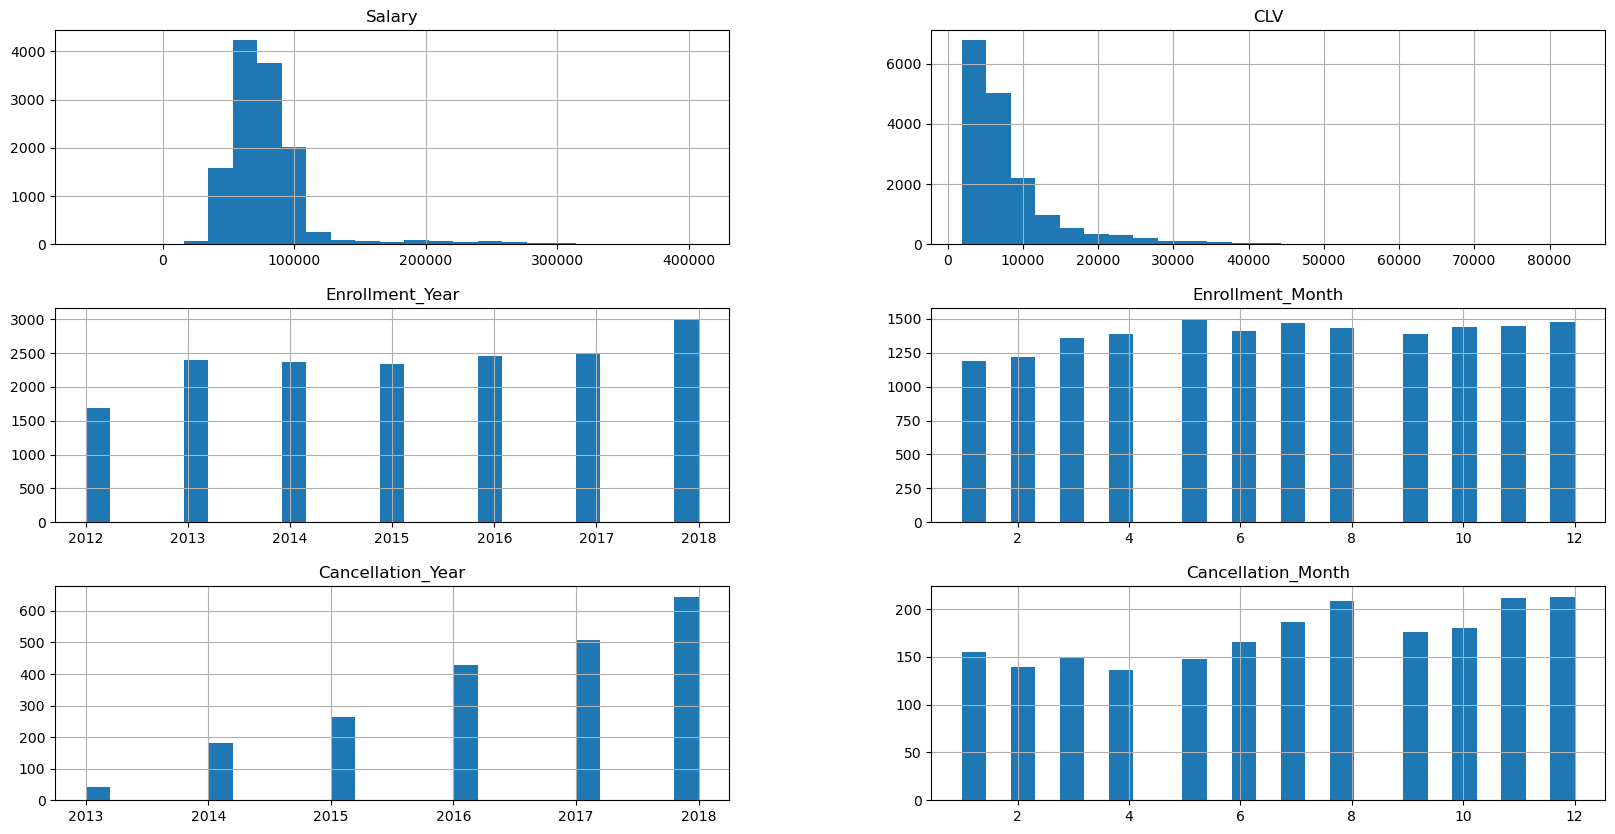

In [238]:
df_CLH[var_num[1:]].hist(bins=25, figsize=(20, 10));

Tenemos **seis histogramas**, uno por cada columna que tenemos de tipo numérica. Vamos a comentarlos brevemente: 

- Histograma **Salary**: representa los ingresos anuales estimados de los clientes donde podemos concluir que los clientes tienen salarios entre los 50000 y 100000, con pocos casos extremos tanto por alto como por bajo. La distribución está concentrada en un rango medio, de ahi la forma de la representación del histograma. 
- Histograma **CLV**: representa el valor total estimado que el cliente aporta a la empresa durante la relación que mantiene con ella. La mayoría de los valores se encuentra en rangos bajos, por lo que podemos decir que hay muchos clientes que aportan poco valor a la empresa y pocos clientes que aportan mucho valor a la empresa. Nos encontramos ante una distribución que se encuentra sesgada a la izquierda. 
- Histograma **Enrollment Year**: representa el año en el que el cliente se inscribió en el programa de lealtad. El número de inscripciones fue aumentando con los años lentamente, teniendo el pico más alto de inscripciones en el 2018. 
- Histograma **Enrollment Month**: representa mes en el que el cliente se inscribió en el programa de lealtad. No podemos decir que haya grande diferencias entre los distintos meses, es decir, los registros se reparten de forma uniforme. 
- Histograma **Cancellation Year**: representa el año en el que el cliente canceló su membresía en el programa de lealtad en el caso de que lo haya cancelado. Las cancelaciones aumentan progresivamente cada año, siendo 2018 el de mayor número, es decir, se observa un incremento en bajas con el tiempo.
- Histograma **Cancellation Month**: representa el mes en el que el cliente canceló su membresía en el programa de lealtad en el caso de que lo haya cancelado. Las cancelaciones se distribuyen de manera relativamente uniforme, siendo agosto y diciembre los meses que muestran picos más altos.

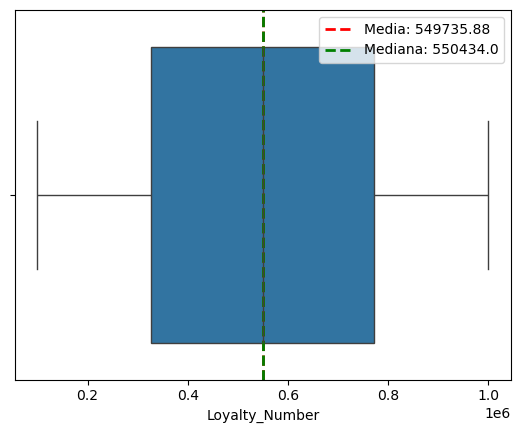

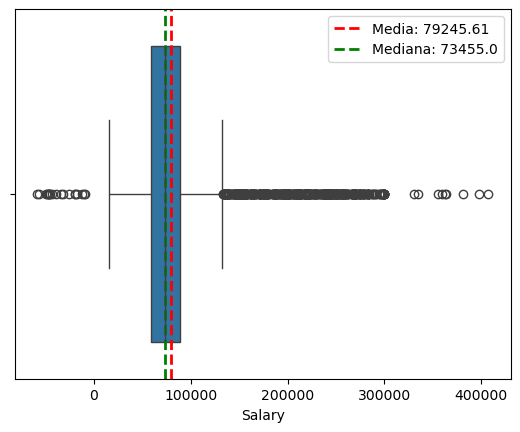

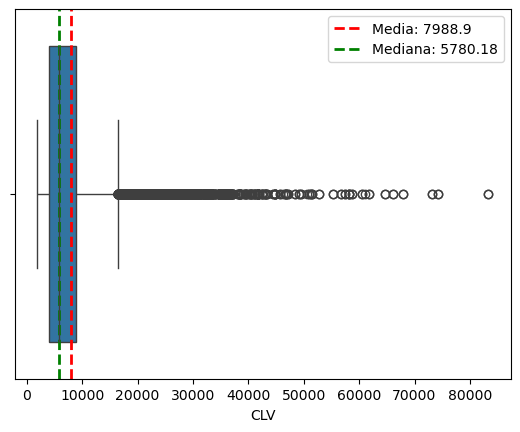

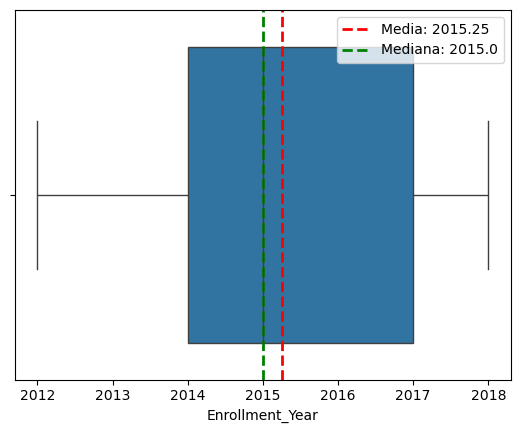

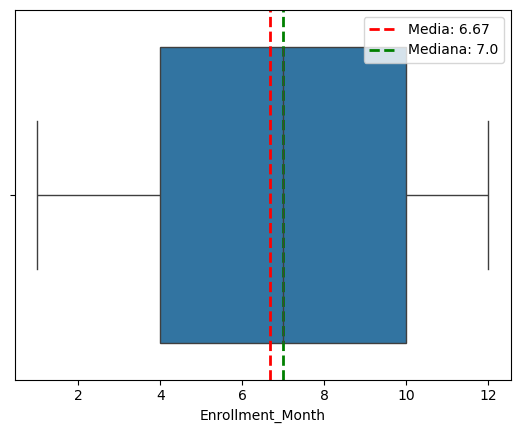

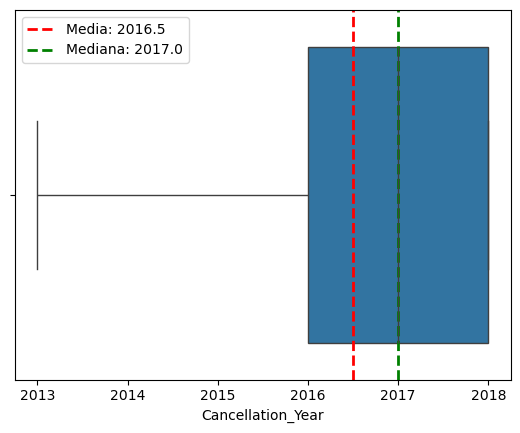

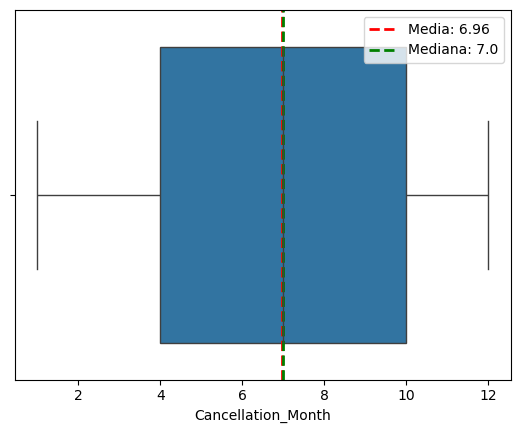

In [239]:
avn_boxplot(df_CLH, var_num)

In [240]:
# DUPLICADOS: 
func_duplicados(df_CLH)

Este dataframe no tiene duplicados.


In [241]:
# NULOS: 
var_nulos_df_CLH = variables_nulas(df_CLH)

,columna,%_nulos
7,Salary,25.321145
14,Cancellation_Year,87.650117
15,Cancellation_Month,87.650117


La siguiente columna tiene valores nulos: Salary
La siguiente columna tiene valores nulos: Cancellation_Year
La siguiente columna tiene valores nulos: Cancellation_Month


In [242]:
# Se tienen tres columnas con variables que tienen valores nulos, para saber como realizar la imputación, vamos a mirar su boxplots. 
# Una vez vistos sus boxplots decidimos imputar con su mediana

mediana_salary = df_CLH['Salary'].median()
mediana_cancellation_year = df_CLH['Cancellation_Year'].median()
mediana_cancellation_month = df_CLH['Cancellation_Month'].median()

df_CLH['Salary'] = df_CLH['Salary'].fillna(mediana_salary)
df_CLH['Cancellation_Year'] = df_CLH['Cancellation_Year'].fillna(mediana_cancellation_year)
df_CLH['Cancellation_Month'] = df_CLH['Cancellation_Month'].fillna(mediana_cancellation_month)

print(f'Valores nulos después de la imputación de Salary: {df_CLH['Salary'].isnull().sum()}')
print(f'Valores nulos después de la imputación de Cancellatior_Year: {df_CLH['Cancellation_Year'].isnull().sum()}')
print(f'Valores nulos después de la imputación de Cancellation_Month: {df_CLH['Cancellation_Month'].isnull().sum()}')

Valores nulos después de la imputación de Salary: 0
Valores nulos después de la imputación de Cancellatior_Year: 0
Valores nulos después de la imputación de Cancellation_Month: 0


In [243]:
# A continuación vamos a unir los dos dataframe: 

df_completo = df_CFA.merge(df_CLH, on = 'Loyalty_Number')
df_completo.head(2)

,Loyalty_Number,Year,Month,Flights_Booked,Flights_with_Companions,Total_Flights,Distance,Points_Accumulated,Points_Redeemed,Dollar_Cost_Points_Redeemed,Country,Province,City,Postal_Code,Gender,Education,Salary,Marital_Status,Loyalty_Card,CLV,Enrollment_Type,Enrollment_Year,Enrollment_Month,Cancellation_Year,Cancellation_Month
0,100018,2017,1,3,0,3,1521,152.0,0,0,Canada,Alberta,Edmonton,T9G_1W3,Female,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,8,2017.0,7.0
1,100102,2017,1,10,4,14,2030,203.0,0,0,Canada,Ontario,Toronto,M1R_4K3,Male,College,73455.0,Single,Nova,2887.74,Standard,2013,3,2017.0,7.0


In [245]:
# Vamos a guardar el fichero completo: 

# df_completo.to_csv('data/df_customer.csv', index=False)

### Fase 2: Visualización

Usando las herramientas de visualización que has aprendido durante este módulo, contesta a las siguientes gráficas usando la mejor gráfica que consideres:

In [361]:
# FUNCIONES:
 
def mes_nomb(mes_num):
    if mes_num == 1: 
        return 'Enero'
    elif mes_num == 2: 
        return 'Febrero'
    elif mes_num == 3: 
        return 'Marzo'
    elif mes_num == 4: 
        return 'Abril'
    elif mes_num == 5: 
        return 'Mayo'
    elif mes_num == 6: 
        return 'Junio'
    elif mes_num == 7: 
        return 'Julio'
    elif mes_num == 8: 
        return 'Agosto'
    elif mes_num == 9: 
        return 'Septiembre'
    elif mes_num == 10: 
        return 'Octubre'
    elif mes_num == 11: 
        return 'Noviembre'
    elif mes_num == 12: 
        return 'Diciembre'
    else: 
        return 'NaN' 

#### **1. ¿Cómo se distribuye la cantidad de vuelos reservados por mes durante el año?**

Vamos a crear un sub-dataframe del dataframe original, donde vamos a tener las columnas: 
  - ``Flights_Booked``
  - ``Month``
  - ``Year``

In [349]:
df_q1 = df_completo[['Flights_Booked', 'Month', 'Year']]
df_q1.sample(5)

,Flights_Booked,Month,Year
193123,6,3,2018
28809,0,2,2017
46287,0,3,2017
130567,0,8,2017
387446,0,12,2018


Vamos a agrupar por `Month` y `Year`, y a sumar los valores de la variable `Flights_Booked`; ya que esta variable es el número total de de vuelos reservados por los clientes en un mes específico. 

In [259]:
df_q1_month_year = df_q1.groupby(['Month', 'Year']).sum('Flights_Booked').reset_index()
df_q1_month_year.head(5)

,Month,Year,Flights_Booked
0,1,2017,47766
1,1,2018,49170
2,2,2017,47691
3,2,2018,48643
4,3,2017,64271


Una vez agrupado, vamos a crear una nueva columna donde los meses en lugar de que esté dado de manera numérica esté dado de manera categórica, para que después cuando hagamos la representación gráfica sea más cómodo de leer. 

In [260]:
df_q1_month_year['Month_Name'] = df_q1_month_year['Month'].apply(mes_nomb)
df_q1_month_year.head(5)

,Month,Year,Flights_Booked,Month_Name
0,1,2017,47766,Enero
1,1,2018,49170,Enero
2,2,2017,47691,Febrero
3,2,2018,48643,Febrero
4,3,2017,64271,Marzo


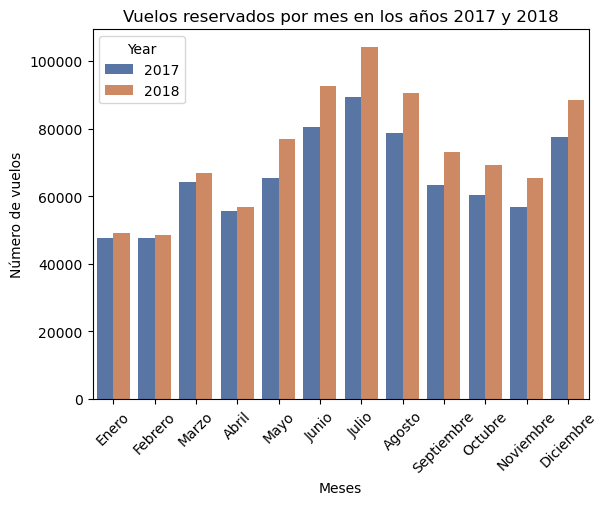

In [261]:
sns.barplot(data=df_q1_month_year, x='Month_Name', y='Flights_Booked' ,hue='Year', palette='deep')
plt.xticks(rotation = 45)
plt.xlabel('Meses')
plt.ylabel('Número de vuelos')
plt.title('Vuelos reservados por mes en los años 2017 y 2018');

Viendo el histograma podríamos indicar que la cantidad de vuelos reservados sigue un patrón estacional, es decir, en los meses de verano (junio, julio y agosto) presenta un pico bastante marcado de reservas, siendo julio el mes que presenta mayor volumen en ambos años. Por otro lado, también sobresale el mes de diciembre como un mes en el que nos encontramos un pico de reservas parecido al que tenemos en agosto, el resto del año la demanda es más estable. Además, en 2018 se registraron más reservas que en 2017 en todos los meses, esto nos indica una tendencia creciente en el número de vuelos.

#### **2. ¿Existe una relación entre la distancia de los vuelos y los puntos acumulados por los clientes?**

Vamos a crear un sub-dataframe del dataframe original, donde vamos a tener las columnas: 
  - ``Distance``
  - ``Points_Accumulated``

In [263]:
df_q2 = df_completo[['Distance', 'Points_Accumulated']]
print(df_q2.head(5))
print(df_q2.shape)

   Distance  Points_Accumulated
0      1521               152.0
1      2030               203.0
2      1200               120.0
3         0                 0.0
4         0                 0.0
(403760, 2)


Una vez tenemos nuestro sub-dataframe creado, pasamos a realizar la representación: 

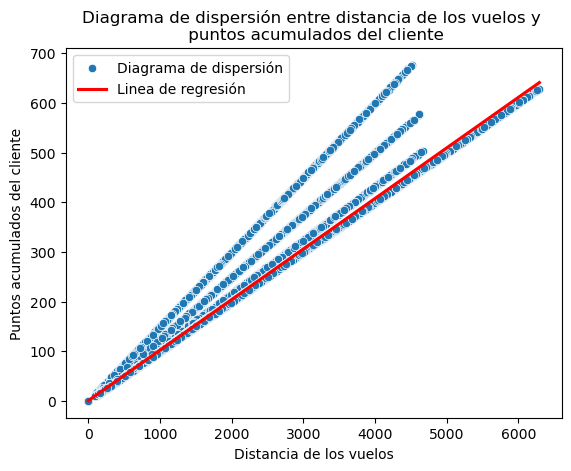

In [275]:
sns.scatterplot(data=df_q2, x='Distance', y='Points_Accumulated', label = 'Diagrama de dispersión')
sns.regplot(data=df_q2, x='Distance', y='Points_Accumulated', scatter=False, color='red', label= 'Linea de regresión')
plt.title('Diagrama de dispersión entre distancia de los vuelos y \n puntos acumulados del cliente')
plt.xlabel('Distancia de los vuelos')
plt.ylabel('Puntos acumulados del cliente')
plt.legend();

El diagrama muestra una relación positiva entre la distacia de los vuelos y los puntos que acumula el cliente, es decir, a mayor distacia del vuelo, mayor es la cantidad de puntos que el cliente obtiene. También observamos en nuestro diagrama que hay diferentes agrupaciones de puntos que habría que esstudiar para saber a que es debido; por ejemplo, podría ser debido al tipo de tarjeta de lealtad que posea el cliente (columna: `Loyalty_Card`). En conclusión, la tendencia de nuestro diagrama de dispersión es lineal y positiva que, además, nuestra linea de regresión nos refleja.  

#### **3. ¿Cuál es la distribución de los clientes por provincia o estado?**

Vamos a crear un sub-dataframe del dataframe original, donde vamos a tener las columnas: 
  - ``Loyalty_Number``
  - ``Province``

In [277]:
df_q3 = df_completo[['Loyalty_Number', 'Province']]
df_q3.head(10)

,Loyalty_Number,Province
0,100018,Alberta
1,100102,Ontario
2,100140,British_Columbia
3,100214,British_Columbia
4,100272,Ontario
5,100301,Ontario
6,100364,Saskatchewan
7,100380,Quebec
8,100428,British_Columbia
9,100504,Ontario


Vamos a hacer otro dataframe donde queremos el recuento y el % del recuento de cada provincia: 

In [321]:
recuento_province = df_q3.groupby('Province')['Loyalty_Number'].count().reset_index()
recuento_province.rename(columns={'Loyalty_Number':'recuento'}, inplace=True)
recuento_province['%_recuento'] = round(100*recuento_province['recuento']/recuento_province['recuento'].sum(), 2)
recuento_province

,Province,recuento,%_recuento
0,Alberta,23360,5.79
1,British_Columbia,106442,26.36
2,Manitoba,15900,3.94
3,New_Brunswick,15352,3.80
4,Newfoundland,6244,1.55
5,Nova_Scotia,12507,3.10
6,Ontario,130258,32.26
7,Prince_Edward_Island,1584,0.39
8,Quebec,79573,19.71
9,Saskatchewan,9861,2.44


Text(0.5, 0, ' ')

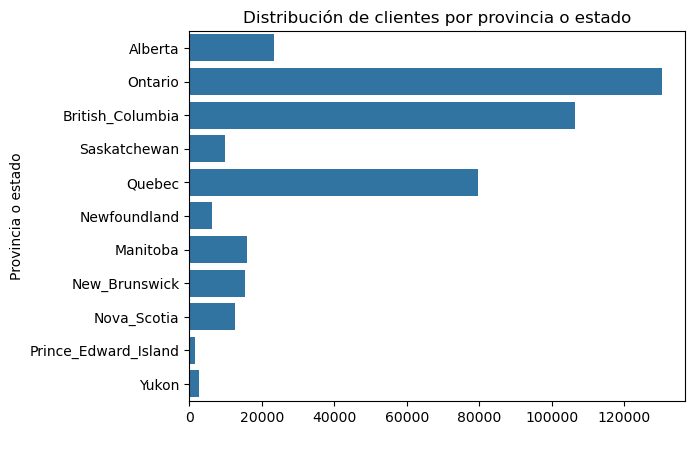

In [ ]:
sns.countplot(data=df_q3, y='Province');
plt.title('Distribución de clientes por provincia o estado')
plt.ylabel('Provincia o estado')
plt.xlabel(' ')


En esta gráfica vemos la distribución de clientes por provincia o estado, donde Ontario concentra la mayor cantidad con 130258 clientes (32.26%), seguido de British Columbia con 106442 clientes (26.36%) y Quebec con 79573 clientes (19.71%), mientras que provincias como Prince Edward Island con 1584 clientes (0.39%) y Yukon con 2679 clientes (0.66%) representan poco mas de un 1% del total. Esto refleja una fuerte concentración de clientes en unas pocas provincias principales.

#### **4. ¿Cómo se compara el salario promedio entre los diferentes niveles educativos de los clientes?**

Vamos a crear un sub-dataframe del dataframe original, donde vamos a tener las columnas: 
  - ``Salary``
  - ``Education``

In [322]:
df_q4 = df_completo[['Salary', 'Education']]
df_q4.head(5)

,Salary,Education
0,92552.0,Bachelor
1,73455.0,College
2,73455.0,College
3,63253.0,Bachelor
4,91163.0,Bachelor


Realizamos un dataframe donde tenemos dos columnas. La primera es el nivel educativo y la segunda la media de cada unos de los niveles educativos. 

In [357]:
media_salary = round(df_q4.groupby('Education')['Salary'].mean().reset_index(), 2)
media_salary.rename(columns={'Salary':'Media'}, inplace=True)
media_salary

,Education,Media
0,Bachelor,72473.47
1,College,73455.00
2,Doctor,178403.68
3,High_School_or_Below,61019.93
4,Master,103734.52


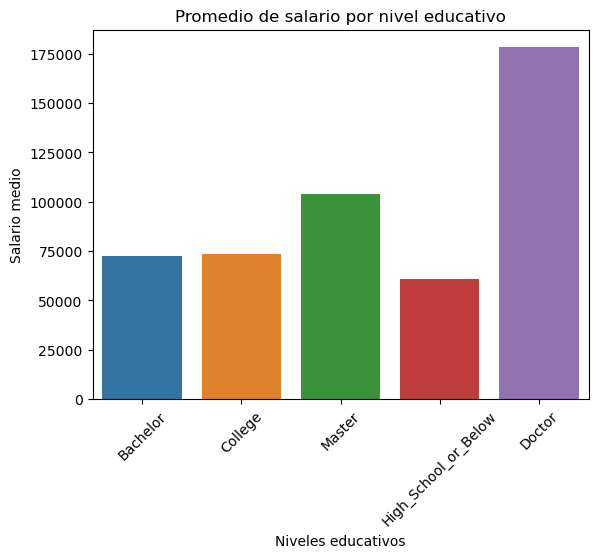

In [360]:
sns.barplot(data=df_q4, x='Education', y='Salary', errorbar=None, hue='Education')
plt.xticks(rotation = 45)
plt.title('Promedio de salario por nivel educativo')
plt.xlabel('Niveles educativos')
plt.ylabel('Salario medio');

Con esta representación gráfica podemos decir que la tendencia es que a mayor nivel educativo, mayor es el salario promedio. Podemos observar que las personas que su nivel educativo es de secundiario o menos perciben los ingresos más bajos, mientras que quienes tienen estudios universitarios logran unos mejores salaros medios, siendo aquellos clientes que tienen un nivel educativo de doctorado los que tienen los salarios más altos diferenciandose bastante de los otros niveles educativos.  

#### **5. ¿Cuál es la proporción de clientes con diferentes tipos de tarjeta de fidelidad?**

Vamos a crear un sub-dataframe del dataframe original, donde vamos a tener las columnas: 
  - ``Loyalty_Number``
  - ``Loyalty_Card``

In [339]:
df_q5 =df_completo[['Loyalty_Number', 'Loyalty_Card']]
df_q5.head(5)

,Loyalty_Number,Loyalty_Card
0,100018,Aurora
1,100102,Nova
2,100140,Nova
3,100214,Star
4,100272,Star


Realizamos un dataframe donde tenemos los diferentes tipos de tarjetas de fidelidad y cuantos clientes con cada tipo de tarjeta.

In [342]:
recuento_loyalty_card = df_q5.groupby('Loyalty_Card')['Loyalty_Number'].count().reset_index()
recuento_loyalty_card.rename(columns={'Loyalty_Number':'recuento'}, inplace=True)
recuento_loyalty_card

,Loyalty_Card,recuento
0,Aurora,83132
1,Nova,136883
2,Star,183745


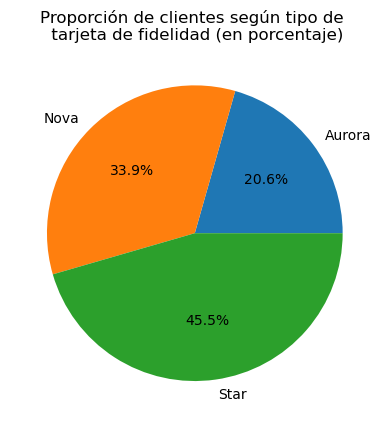

In [346]:
plt.pie(data=recuento_loyalty_card, x = 'recuento', labels='Loyalty_Card', autopct='%.1f%%')
plt.title('Proporción de clientes según tipo de \n tarjeta de fidelidad (en porcentaje)');

La gráfica muestra la distribución de clientes según el tipo de tarjeta de fidelidad que poseen. El mayor grupo corresponde a la tarjeta *Star*, que concentra casi la mitad de los clientes (45.5%), lo que indica que es la opción más popular. En segundo lugar se encuentra la tarjeta *Nova*, con un 33.9% de participación, representando a un tercio de los clientes. Finalmente, la tarjeta *Aurora* es la menos popular, con un 20.6% del total. En conclusión, los datos reflejan una clara preferencia por la tarjeta *Star*, aunque Nova también tiene una presencia relevante en comparación con Aurora.

#### **6. ¿Cómo se distribuyen los clientes según su estado civil y género?**

Vamos a crear un sub-dataframe del dataframe original, donde vamos a tener las columnas: 
  - ``Loyalty_Number``
  - ``Marital_Status``
  - ``Gender``

In [348]:
df_q6 = df_completo[['Loyalty_Number', 'Marital_Status', 'Gender']]
df_q6.head(5)

,Loyalty_Number,Marital_Status,Gender
0,100018,Married,Female
1,100102,Single,Male
2,100140,Divorced,Female
3,100214,Married,Male
4,100272,Divorced,Female


Realizamos otro dataframe donde tenemos un recuento según estado civil y género. 

In [352]:
df_q6_estado = df_q6.groupby(['Marital_Status', 'Gender']).count().reset_index()
df_q6_estado.rename(columns={'Loyalty_Number':'recuento'}, inplace=True)
df_q6_estado

,Marital_Status,Gender,recuento
0,Divorced,Female,30634
1,Divorced,Male,30128
2,Married,Female,117363
3,Married,Male,117482
4,Single,Female,54760
5,Single,Male,53393


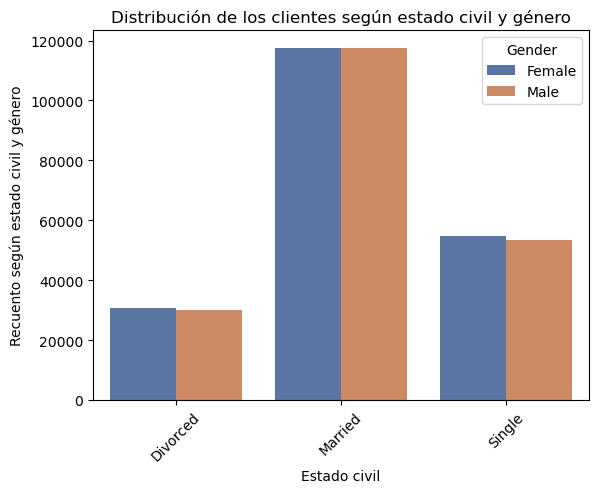

In [356]:
sns.barplot(data=df_q6_estado, x='Marital_Status', y='recuento' ,hue='Gender', palette='deep')
plt.xticks(rotation = 45)
plt.xlabel('Estado civil')
plt.ylabel('Recuento según estado civil y género')
plt.title('Distribución de los clientes según estado civil y género');

La gráfica muestra la distribución de clientes según estado civil y género. El grupo más numeroso corresponde a las personas casadas, con cifras muy similares entre hombres (117482) y mujeres (117363), lo que refleja un equilibrio en esta categoría. En segundo lugar se encuentran los solteros, con un número también parecido entre ambos géneros (hombres: 53393 y mujeres: 54760), aunque significativamente menor que el de casados. Por último, los divorciados representan la proporción más pequeña dentro de la muestra, nuevamente sin grandes diferencias entre hombres(30128) y mujeres(30634). En conclusión, se observa una fuerte concentración de clientes en el estado civil de casados, mientras que solteros y divorciados tienen una presencia más reducida.